In [19]:
from data_utils import load_features
from transforms import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.models import load_model
import os
%matplotlib inline

## Load resampled time domain features

In [2]:
%time X, y, files = load_features('train_1', [LPF(5.0), Resample(600)])

Wall time: 7.85 s


In [3]:
print X.shape
X = X.reshape(1267, X.shape[1]*X.shape[2])

(1267L, 16L, 600L)


## 70/30 cv split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1337)

## Scale to zero mean and unit variance

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Data Augmentation to balance classes with smote

In [6]:
sm = SMOTE(kind='regular')
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

## Reshape to (N, channels, samples, 1) for 2d convnet

In [7]:
X_train_2d_sm = X_train_sm.reshape((len(X_train_sm), 16, 600, 1))
X_test_2d = X_test.reshape((len(X_test), 16, 600, 1))

## Build simple 2d convnet

In [8]:
cnn = Sequential()
cnn.add(Convolution2D(64, 3, 1, activation="relu", input_shape=(16, 600, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 1)))
cnn.add(Flatten())
cnn.add(Dense(512, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, init='normal', activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(patience=20)

In [ ]:
cnn.fit(X_train_2d_sm, y_train_sm, nb_epoch=3, batch_size=32, validation_data=(X_test_2d, y_test), callbacks=[earlystop])

In [11]:
preds = cnn.predict_classes(X_test_2d)
preds_train = cnn.predict_classes(X_train_2d_sm)

1472/1498 [============================>.] - ETA: 0s

## Confusion matrix and ROC score train

AUC: 0.987984


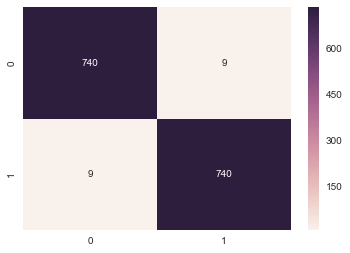

In [14]:
sns.heatmap(confusion_matrix(y_train_sm, preds_train), annot=True, fmt='d')
print "AUC: %f" % (roc_auc_score(y_train_sm, preds_train))

## Confusion matrix and ROC score trest

AUC: 0.497354


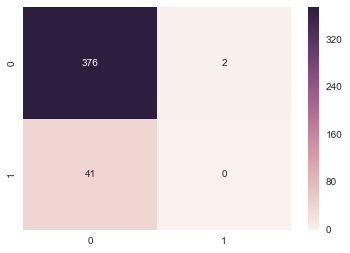

In [15]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')
print "AUC: %f" % (roc_auc_score(y_test, preds))

## Load current best model
cnn only trained for 3 epochs

In [30]:
cnn2 = load_model(os.path.join('trained_models', 'cnn1_lpf5.0_resample600_smote.h5'))

In [31]:
preds2 = cnn2.predict_classes(X_test_2d)
preds2_train = cnn2.predict_classes(X_train_2d_sm)

1440/1498 [===========================>..] - ETA: 0s

AUC: 0.979306


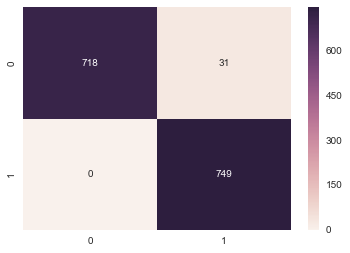

In [32]:
sns.heatmap(confusion_matrix(y_train_sm, preds2_train), annot=True, fmt='d')
print "AUC: %f" % (roc_auc_score(y_train_sm, preds2_train))

AUC: 0.973545


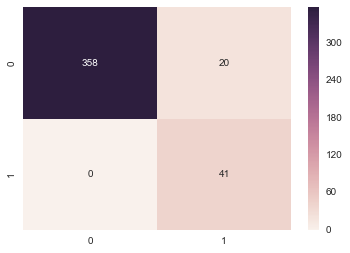

In [33]:
sns.heatmap(confusion_matrix(y_test, preds2), annot=True, fmt='d')
print "AUC: %f" % (roc_auc_score(y_test, preds2))

In [48]:
from keras.utils.visualize_util import plot
plot(cnn2)

RuntimeError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [ ]:
cnn2